In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [3]:
path = "../input/creditcardfraud/creditcard.csv"
df = pd.read_csv(path)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [7]:
font = {'family': 'serif',        
        'weight': 'normal',
        'size': 16,
        }

Text(0, 0.5, 'Frecuency')

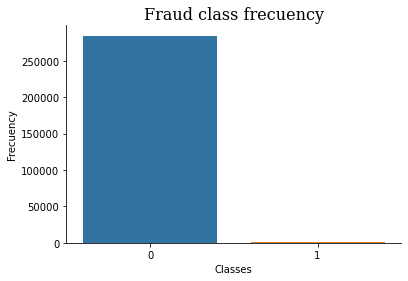

In [8]:
df_class = df.Class.value_counts().reset_index()
sns.barplot(x="index",y="Class",data=df_class)
sns.despine()
plt.title("Fraud class frecuency",fontdict=font)
plt.xlabel("Classes")
plt.ylabel("Frecuency")

### The data is unbalanced!
What can we do to avoid this problem ? 

* Collect more data
* Changing the performance metric
* Resampling the dataset

Well, let's see how we solve it! 

Before we start let's do a little EDA to see what we find of interest.

Let's start by exploring if there are differences between the Fraud and Non-Fraud classes

In [9]:
#We separate the classes
fraud = df[df.Class == 1]
non_fraud = df[df.Class == 0]

In [17]:
#We use describe for the Time and Amount columns
print("Fraud values")
fraud[["Time","Amount"]].describe()

Fraud values


,Time,Amount
count,492.000000,492.000000
mean,80746.806911,122.211321
std,47835.365138,256.683288
min,406.000000,0.000000
25%,41241.500000,1.000000
50%,75568.500000,9.250000
75%,128483.000000,105.890000
max,170348.000000,2125.870000


In [16]:
print("Non Fraud values")
non_fraud[["Time","Amount"]].describe()

Non Fraud values


,Time,Amount
count,284315.000000,284315.000000
mean,94838.202258,88.291022
std,47484.015786,250.105092
min,0.000000,0.000000
25%,54230.000000,5.650000
50%,84711.000000,22.000000
75%,139333.000000,77.050000
max,172792.000000,25691.160000


In [ ]:
We can see that half of them are usually small amount frauds: from 0 to 25% the amount is equal or less than 1 usd, from 25 to 50% between 1 and 9 usd.

We also found that in both cases there could be outliers, especially in the cases of Non Fraud ( 25691 usd !).

Let's make a scatter plot, using the Time and Amount columns, to see how they relate to each other: Fraud and Non Fraud

In [22]:
plt.figure(figsize=(14,8))
color_dict = {0:"#E3E3E3",1:"#FD0B3B"}
sns.scatterplot(x="Time",y="Amount", size="Amount",data=df,alpha=0.7,hue="Class",palette=color_dict,legend="full")
plt.title("Time-Amount relationship between Fraud and Non-Fraud cases",fontdict=font)
plt.xlabel("Time")
plt.ylabel("Amount")


KeyboardInterrupt: 

This dataset has been previously scaled (PCA) but there are two columns ("Amount", "Time") that haven't done it yet. let's do it ! 

In [75]:
# RobustScaler is less prone to outliers
scaler = RobustScaler()
df["scaled_amount"] = scaler.fit_transform(df["Amount"].values.reshape(-1,1))
df["scaled_time"] = scaler.fit_transform(df["Time"].values.reshape(-1,1))

df.drop(["Amount","Time"],axis=1,inplace=True)


In [76]:
# Splitting the Data 
X = df.drop("Class",axis=1)
y = df.Class

In [77]:
# train, test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

In [78]:
# See if both the train and test label distribution are similarly distributed
print("Label distribution y_train")
print(y_train.value_counts(normalize=True))
print("Label distribution y_test")
print(y_test.value_counts(normalize=True))

Label distribution y_train
0    0.998271
1    0.001729
Name: Class, dtype: float64
Label distribution y_test
0    0.99828
1    0.00172
Name: Class, dtype: float64


In [ ]:
As we have seen, our dataframe is not balanced, so we will create a sub-sample where the classes are  distributed 70/30 (I don't want to use 50/50 so I don't lose a lot of data). It is true that with this technique the algorithm can work better but a lot of information is lost that could be useful.

We will use X_train and y_train to do this, reserving the Test to validate .

Now I will do the following, using the indexes, I will take all the cases where Class=1, and then, to maintain the 70/30 proportion, taking 919 data where Class=0, to, finally using pd.concat, create the sub_sample (30% = 394, 70%=919)

There are three cases of Imbalance — Mild, Moderate, and Extreme; depends on the minority class proportion to the whole dataset:if the minority class ratio is between 20-40% it is considered Mild, between 1-20% Moderate and less than 1% Extreme.

If I had a lot of data I could do a 50/50 ratio but this is not the case, this is the reason I am using the 70/30 ratio in order to keep some data.

In [85]:
#First with value counts we see how many values we have from each class
y_train.value_counts()

0    227451
1       394
Name: Class, dtype: int64

In [90]:
# here we have all fraud cases
X_fraud = df.loc[y_train.loc[y_train == 1].index]

In [91]:
# 919 values where Class=0
y_non_fraud = df.loc[y_train.loc[y_train == 0].index][:919]

In [92]:
#concat
sub_sample = pd.concat([X_fraud,y_non_fraud],axis=0)

In [93]:
#finally a sub_sample with 70/30 proportions
sub_sample.shape

(1313, 31)

Text(0, 0.5, 'Frecuency')

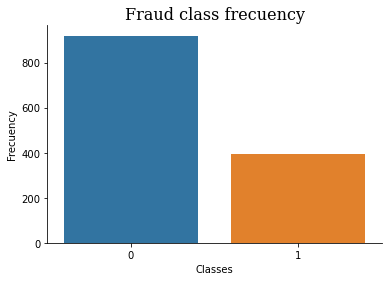

In [94]:
new_df_class = sub_sample.Class.value_counts().reset_index()
sns.barplot(x="index",y="Class",data=new_df_class)
sns.despine()
plt.title("Fraud class frecuency",fontdict=font)
plt.xlabel("Classes")
plt.ylabel("Frecuency")

### In search of the Model..

In [95]:
# split normalize data
X_new = sub_sample.drop("Class",axis=1)
y_new = sub_sample.Class


We have made a small function, like baseline, to test some classification algorithms and see how they behave. 

I'm going to use all the data I have and validate it with cross validation; I don't want to use Train and Test to take advantage of all the data available which are few (1313,31)




In [96]:
from sklearn.model_selection import cross_val_predict
def baseline_roc_curve_cv(X,y):
    models = {"rid":RidgeClassifier(),"log":LogisticRegression(),                 
    "rdf":RandomForestClassifier(),"kne":KNeighborsClassifier(),"svc":SVC()}  
    
    df_results = {"Model":[],"False_positive_rate":[],"True_positive_rate":[]} 
    
    for key,model in models.items():        
        y_predict = cross_val_predict(model,X,y,cv=5)
        fpr, tpr, thresholds = roc_curve(y, y_predict)
        df_results["Model"].append(str(model))
        df_results["False_positive_rate"].append(round(fpr[1],2))
        df_results["True_positive_rate"].append(round(tpr[1],2))

    return pd.DataFrame(data=df_results)

In [97]:
baseline_roc_curve_cv(X=X_new,y=y_new)

,Model,False_positive_rate,True_positive_rate
0,RidgeClassifier(),0.01,0.77
1,LogisticRegression(),0.01,0.91
2,RandomForestClassifier(),0.01,0.88
3,KNeighborsClassifier(),0.01,0.87
4,SVC(),0.01,0.86


The metric used is Roc Curve that returns True positive rate and False positive rate.
We see that the great majority, with the balanced dataset, behaves quite well with True positive rate (recall).

We will focus on Logistic and RandomForest Classifier:
First we will see how they behave with the original dataset and then we will try to use hyperparameters to get better results

### Logistic Regression

In [102]:
model = LogisticRegression(random_state=0)
model.fit(X_new,y_new)
# let,s see how they behave with the original dataset 
y_predict = model.predict(X_test) 
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
print(f"False Positive Rate: {round(fpr[1],2)}")
print(f"True Positive Rate: {round(tpr[1],2)}")

False Positive Rate: 0.01
True Positive Rate: 0.88


In [105]:
# we will try to use hyperparameters to get better results
param_grid = [
    {
     'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear','newton-cg', 'lbfgs']
    }]

grid = GridSearchCV(estimator=LogisticRegression(),param_grid=param_grid,cv=5)
grid.fit(X_new,y_new)




GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'penalty': ['l1', 'l2'],
                          'solver': ['liblinear', 'newton-cg', 'lbfgs']}])

In [106]:
grid.best_params_

{'C': 545.5594781168514, 'penalty': 'l2', 'solver': 'liblinear'}

In [107]:
model = LogisticRegression(random_state=0,C=545.5594781168514, penalty = 'l2', solver= 'liblinear')
model.fit(X_new,y_new)
# let,s see how they behave with the original dataset 
y_predict = model.predict(X_test) 
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
print(f"False Positive Rate: {round(fpr[1],2)}")
print(f"True Positive Rate: {round(tpr[1],2)}")

False Positive Rate: 0.02
True Positive Rate: 0.88


Well we haven't improved the results after using GridCV either. Let's see what happens with RandomForest!

In [108]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_new,y_new)
# let,s see how they behave with the original dataset 
y_predict = rf.predict(X_test) 
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
print(f"False Positive Rate: {round(fpr[1],2)}")
print(f"True Positive Rate: {round(tpr[1],2)}")

False Positive Rate: 0.01
True Positive Rate: 0.87


In [110]:
# we will try to use hyperparameters to get better results. I will use RandomizeSearch instead of GridCV beacause it is faster in this case
param_grid = [{     
    'n_estimators' : list(range(100,1000,100)),
    'max_features' : ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]}
        ]

search = RandomizedSearchCV(estimator=RandomForestClassifier(),param_distributions=param_grid,n_jobs=1,random_state=0,cv=3)
#fit
search.fit(X_new,y_new)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=1,
                   param_distributions=[{'max_depth': [10, 20, 30, 40, 50, 60,
                                                       70, 80, 90, 100, None],
                                         'max_features': ['auto', 'sqrt',
                                                          'log2'],
                                         'min_samples_leaf': [1, 2, 4],
                                         'min_samples_split': [2, 5, 10],
                                         'n_estimators': [100, 200, 300, 400,
                                                          500, 600, 700, 800,
                                                          900]}],
                   random_state=0)

In [111]:
search.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 20}

In [112]:
rf = RandomForestClassifier(random_state=0,n_estimators=800,min_samples_split= 2,min_samples_leaf=2,
                            max_features= 'auto',max_depth= 20)
rf.fit(X_new,y_new)
# let,s see how they behave with the original dataset 
y_predict = rf.predict(X_test) 
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
print(f"False Positive Rate: {round(fpr[1],2)}")
print(f"True Positive Rate: {round(tpr[1],2)}")

False Positive Rate: 0.01
True Positive Rate: 0.87


In [113]:
from sklearn.metrics import classification_report
print ("")
print ("Classification Report: ")
print (classification_report(y_test, y_predict))



Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.16      0.87      0.26        98

    accuracy                           0.99     56962
   macro avg       0.58      0.93      0.63     56962
weighted avg       1.00      0.99      0.99     56962



We haven't improved much using hyperparameters either. We have focused on Recall rather than Precision for this type of problem.

There is still a lot of work to be done: using synthetic data, outliers treatments, deep learning...
but for now I am satisfied with the work, although I suppose that it would never reach production; so I will continue reading more Kaggle Notebooks to continue learning...

Translated with www.DeepL.com/Translator (free version)